In [25]:
import torch
from torch.utils.data.dataloader import DataLoader
from torch.utils.data.dataset import Dataset, TensorDataset
from torchvision import transforms, utils
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image

In [26]:
ROOT = "/StudentData/HW2/train/"
TestFolder  = "/StudentData/HW2/test/"

In [27]:
class ImageDataset(Dataset):
    def __init__(self,root,transform=None):
        super().__init__()
        self.root = root
        self.transform = transform
        self.idxtoImage = {i:file for i,file in enumerate(os.listdir(self.root))}

        
    def __len__(self):
        return len(self.idxtoImage)
    
    def __getitem__(self,idx):
        file = self.idxtoImage[idx]
        image = Image.open(self.root+file).convert("RGB")
        if self.transform !=None:
            image = self.transform(image)

        label = int(file.split('_')[1].split('.')[0])
        return image,label,file
        

In [28]:
# Hyper Parameters
num_epochs = 10
batch_size = 100
learning_rate = 0.001

transform_train = transforms.Compose([transforms.Resize((48,48)),transforms.ToTensor(),transforms.Normalize((0.5226, 0.4494, 0.4206), (0.2336, 0.2224, 0.2187))])
transform_test = transforms.Compose([transforms.Resize((48,48)),transforms.ToTensor(),transforms.Normalize((0.5226, 0.4494, 0.4206), (0.2336, 0.2224, 0.2187))])

train_dataset = ImageDataset(ROOT,transform_train)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size, 
                                           shuffle=True)

test_dataset = ImageDataset(TestFolder,transform_test)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                           batch_size=batch_size, 
                                           shuffle=False)

In [29]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3,stride=2))
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3,stride=2))
        
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2))
        
        self.layer4 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=2),
            nn.ReLU())
        
        self.fc1 = nn.Linear(2*2*128, 256)
        self.ReLU = nn.ReLU()
        self.fc2 = nn.Linear(256,2)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)

        out = out.view(out.size(0), -1)
  
        out = self.fc1(out)
        out = self.ReLU(out)
        out = self.fc2(out)       

        return out

In [30]:
def to_gpu(x):
    return x.cuda() if torch.cuda.is_available() else x

In [35]:
model = Model()
model = to_gpu(model)
    
# convert all the weights tensors to cuda()
# Loss and Optimizer

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

print('number of parameters: ', sum(param.numel() for param in model.parameters()))
print(f'Num of trainable parameters : {sum(p.numel() for p in model.parameters() if p.requires_grad)}')

number of parameters:  221058
Num of trainable parameters : 221058


In [54]:
# train_losses = []
# train_f1scores = []
# test_losses = []
# test_f1scores = []
for epoch in range(num_epochs):
    for i, (images, labels,files) in enumerate(train_loader):
        images = to_gpu(images)
        labels = to_gpu(labels)
        optimizer.zero_grad()
        outputs = model(images)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        if ((i+1) % 100) == 0:
            print ('Epoch [%d/%d], Iter [%d/%d] Loss: %.4f' 
                   %(epoch+1, num_epochs, i+1,
                     len(train_dataset)//batch_size, loss.item()))
    
    train_loss = 0.0
    train_tp = 0.0
    train_fp = 0.0
    train_fn = 0.0
    
    for images, labels,files in train_loader:
        images = to_gpu(images)
        labels = to_gpu(labels)
        outputs = model(images)
        train_loss += criterion(outputs,labels).item()

        _, predicted = torch.max(outputs.data, 1)

        train_tp += ((predicted.cpu() == 1) & (labels.cpu()==1)).sum()
        train_fp += ((predicted.cpu() == 1) & (labels.cpu()==0)).sum()
        train_fn += ((predicted.cpu() == 0) & (labels.cpu()==1)).sum()
    
    
    train_loss = train_loss/len(train_loader)
    train_f1 = 100*((2 * train_tp) / (2*train_tp + train_fp + train_fn))
    
    train_losses.append(train_loss)
    train_f1scores.append(train_f1)
    print('loss of the model on the train images: ',train_loss,'%')
    print('f1 of the model on the train images: ',train_f1.item(),'%')
    
    test_loss = 0.0
    test_tp = 0.0
    test_fp = 0.0
    test_fn = 0.0
    
    for images, labels,files in test_loader:
        images = to_gpu(images)
        labels = to_gpu(labels)
        outputs = model(images)
        test_loss += criterion(outputs,labels).item()

        _, predicted = torch.max(outputs.data, 1)

        test_tp += ((predicted.cpu() == 1) & (labels.cpu()==1)).sum()
        test_fp += ((predicted.cpu() == 1) & (labels.cpu()==0)).sum()
        test_fn += ((predicted.cpu() == 0) & (labels.cpu()==1)).sum()
    
    
    test_loss = test_loss/len(test_loader)
    test_f1 = 100*((2 * test_tp) / (2*test_tp + test_fp + test_fn))
    
    test_losses.append(test_loss)
    test_f1scores.append(test_f1)
    print('loss of the model on the test images: ',test_loss,'%')
    print('f1 of the model on the test images: ',test_f1.item(),'%')
    
#     if accuracy>=98:
#         torch.save(model.state_dict(), 'model_98.pkl')

Epoch [1/10], Iter [100/182] Loss: 0.0963
loss of the model on the train images:  0.04064642771813876 %
f1 of the model on the train images:  98.74430847167969 %
loss of the model on the test images:  0.09102806302367664 %
f1 of the model on the test images:  97.40416717529297 %
Epoch [2/10], Iter [100/182] Loss: 0.0663
loss of the model on the train images:  0.04345162493008815 %
f1 of the model on the train images:  98.6676025390625 %
loss of the model on the test images:  0.09777886521254407 %
f1 of the model on the test images:  97.20923614501953 %
Epoch [3/10], Iter [100/182] Loss: 0.0554
loss of the model on the train images:  0.045375569133199956 %
f1 of the model on the train images:  98.60484313964844 %
loss of the model on the test images:  0.10280100561556269 %
f1 of the model on the test images:  96.60733032226562 %
Epoch [4/10], Iter [100/182] Loss: 0.0076
loss of the model on the train images:  0.033533169862513985 %
f1 of the model on the train images:  98.91592407226562

In [30]:
torch.save(model.state_dict(), 'model_97.pkl')

In [77]:
model = Model()
model.load_state_dict(torch.load('model.pkl'))
model.eval()

Model(
  (layer1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer4): Sequential(
    (0): Conv2d(64, 128, kernel_size=(2, 2), stride=(1, 1))
    (1): ReLU()
  )
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (ReLU): ReLU()
  (fc2): Linear(in_features=256, out_features=2, bias=True)
)

In [21]:
model.eval() 
tp = 0.0
fp = 0.0
fn = 0.0
tn = 0.0
for images, labels,files in test_loader:
    images = to_gpu(images)
    outputs = model(images)

    _, predicted = torch.max(outputs.data, 1)

    tp += ((predicted.cpu() == 1) & (labels==1)).sum()
    fp += ((predicted.cpu() == 1) & (labels==0)).sum()
    fn += ((predicted.cpu() == 0) & (labels==1)).sum()
    tn += ((predicted.cpu() == 0) & (labels==0)).sum()

        
f1 = 100*((2 * tp) / (2*tp + fp + fn))

print('f1 of the model on the test images: ',f1.item(),'%')


f1 of the model on the test images:  97.61869049072266 %


In [ ]:
mean = 0.
std = 0.
nb_samples = 0.
for (images, labels,files) in train_loader:
    batch_samples = images.size(0)
    data = images.view(batch_samples, images.size(1), -1)
    mean += data.mean(2).sum(0)
    std += data.std(2).sum(0)
    nb_samples += batch_samples

mean /= nb_samples
std /= nb_samples

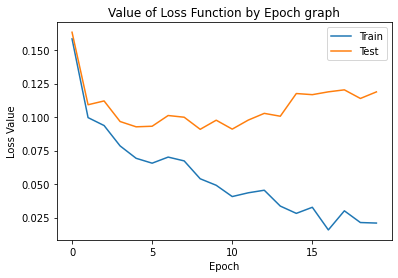

In [70]:
plt.locator_params(nbins=8)
plt.plot(train_losses,label='Train')
plt.plot(test_losses,label='Test')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.title('Value of Loss Function by Epoch graph')
plt.legend()

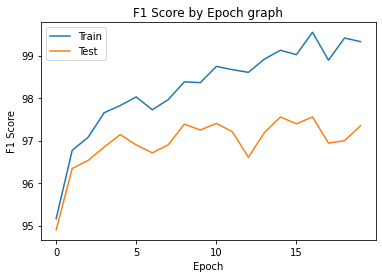

In [66]:
plt.locator_params(nbins=7)
plt.plot(train_f1scores,label='Train')
plt.plot(test_f1scores,label='Test')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.title('F1 Score by Epoch graph')
plt.legend()

In [81]:
train_loader_all = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=2, 
                                           shuffle=False)
for images, labels,files in train_loader_all:
        softmax = nn.Softmax()
        outputs = softmax(model(images))
        print(labels,outputs)
        break

tensor([1, 1]) tensor([[2.5494e-04, 9.9975e-01],
        [1.5627e-04, 9.9984e-01]], grad_fn=<SoftmaxBackward>)


/home/student/.conda/envs/hw2/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


In [71]:
len(train_dataset)

18259